<a href="https://colab.research.google.com/github/ArashDehghanyan/ml-practicres/blob/main/Transfer_learning_and_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import os
import tensorflow as tf
print(tf.__version__)

2.8.0


#Data Preprocessing
###Download data

In [3]:
data_url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cat_and_dogs.zip', origin=data_url, extract=True)
print(path_to_zip)


68616192/68606236 [==============================] - 0s 0us/step
/root/.keras/datasets/cat_and_dogs.zip


In [4]:
data_dir = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

BATCH_SIZE = 32
IMAGE_SIZE = (160, 160)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir, 
    shuffle=True, 
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


##Show the first nine examples

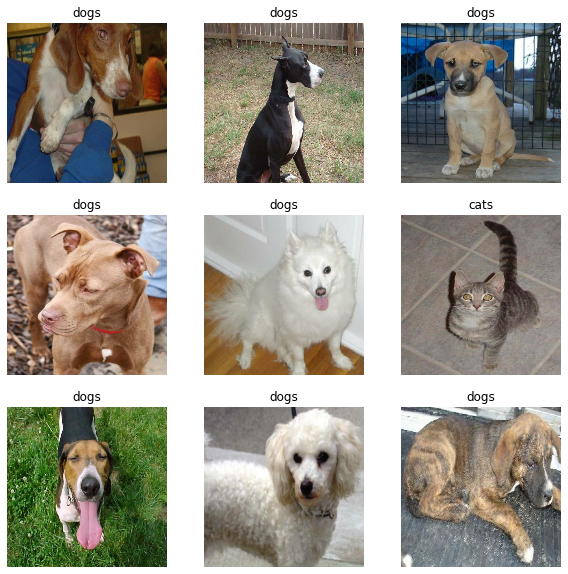

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
print(val_batches)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print(tf.data.experimental.cardinality(test_dataset))
print(tf.data.experimental.cardinality(validation_dataset))

tf.Tensor(32, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(26, shape=(), dtype=int64)


In [7]:
from tensorflow.python.data.ops.dataset_ops import AUTOTUNE
# Configure the dataset
AUTOMATE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

###Data Augmentation

In [8]:
data_augmentation = tf.keras.Sequential(
    [
     tf.keras.layers.RandomFlip('horizontal'),
     tf.keras.layers.RandomRotation(0.2),
     tf.keras.layers.RandomZoom(0.1)
    ]
)

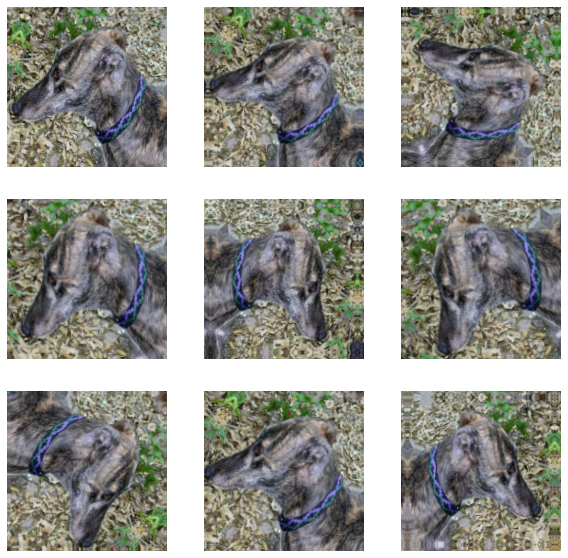

In [10]:
# Repeatedly apply augmentation
plt.figure(figsize=(10, 10))

for image , _ in train_dataset.take(1):
    first_image = image[0]
    for i in range(9):
        plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255.)
        plt.axis('off')

In [11]:
# Rescale inputs
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMAGE_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE, include_top=False, weights='imagenet'
)

9420800/9406464 [==============================] - 0s 0us/step


In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [13]:
# Freeze the convolutional base model
base_model.trainable = False

In [14]:
# Take a look at base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_avrage = global_average_layer(feature_batch)
print(feature_batch_avrage.shape)

(32, 1280)


In [17]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_avrage)
print(prediction_batch.shape)

(32, 1)


##Build a model using tensorflow functional API

In [18]:
inputs = tf.keras.layers.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


###Compile the model

In [19]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [20]:
len(model.trainable_variables)

2

##Train the model

In [21]:
initial_epochs = 10

loss0, acc0 = model.evaluate(validation_dataset)
print("Initial loss: {:.2f}".format(loss0))
print("Initial accuracy: {:.2f}".format(acc0))

26/26 [==============================] - 17s 553ms/step - loss: 0.7658 - accuracy: 0.5285
Initial loss: 0.77
Initial accuracy: 0.53


In [22]:
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset
)

Epoch 1/10
63/63 [==============================] - 64s 946ms/step - loss: 0.7119 - accuracy: 0.5855 - val_loss: 0.5140 - val_accuracy: 0.7017
Epoch 2/10
63/63 [==============================] - 55s 875ms/step - loss: 0.5457 - accuracy: 0.7140 - val_loss: 0.3768 - val_accuracy: 0.8156
Epoch 3/10
63/63 [==============================] - 56s 890ms/step - loss: 0.4281 - accuracy: 0.7835 - val_loss: 0.2931 - val_accuracy: 0.8713
Epoch 4/10
63/63 [==============================] - 58s 925ms/step - loss: 0.3788 - accuracy: 0.8195 - val_loss: 0.2375 - val_accuracy: 0.9121
Epoch 5/10
63/63 [==============================] - 57s 902ms/step - loss: 0.3284 - accuracy: 0.8535 - val_loss: 0.2018 - val_accuracy: 0.9332
Epoch 6/10
63/63 [==============================] - 58s 924ms/step - loss: 0.3017 - accuracy: 0.8645 - val_loss: 0.1845 - val_accuracy: 0.9332
Epoch 7/10
63/63 [==============================] - 58s 917ms/step - loss: 0.2700 - accuracy: 0.8775 - val_loss: 0.1663 - val_accuracy: 0.9418

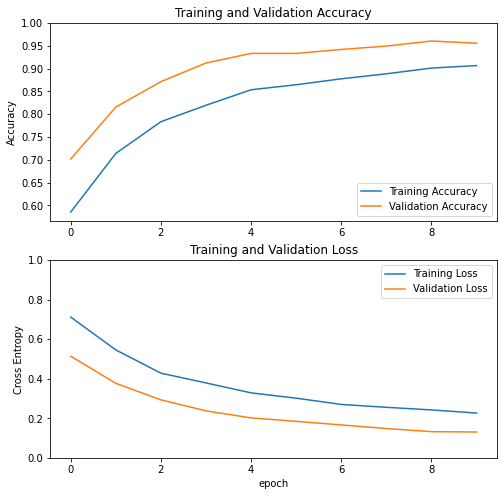

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()